# Basic example

In this tutorial our goals are to learn:
- How to use `bartiq` to implement a quantum algorithm from a paper.
- How to obtain resource estimates for that algorithm.
- What the most important concepts used in `bartiq` are.

<div class="alert alert-block alert-info admonition note"> <p class="admonition-title"><b>NOTE:</b></p>

This tutorial, as well as all the other tutorials, has been written as a jupyter notebook.
If you're reading it online, you can either keep reading, or go to `docs/tutorials` to explore them in a more interactive way!

</div>

Before we start implementing some real algorithms, let's consider the following simple routine:

![title](../images/basic_example.png)

In `bartiq` the basic concept for representing both the whole algorithm as well as all the building blocks is *routine*.
So what do we know about the routines from the picture above?

- Our main routine is called "my algorithm"
- It consists of two subroutines: "A" and "B".
- It takes in a register of size "n".

How do we express this in `bartiq`? 
We do that using the [`QREF` format](https://github.com/PsiQ/qref) – a format for expressing algorithms that we developed with QREs in mind. So let's write our first routine:

In [1]:
my_algorithm = {
    "name": "my_algorithm",
    "type": None,
    "ports": [
        {"name": "in", "direction": "input", "size": "n"},
        {"name": "out", "direction": "output", "size": None},
    ],
}

What do we have here?

- `name`: name of the routine
- `type`: in this case we don't define the type, but in more complex algorithms you might want to add types, such as "basic_gate" or "comparator".
- `ports`: ports define the interface of the routine. The size of the input port is equal to `n` and in general, we won't know the size of the output port until we perform the compilation.

What are we missing? Children.

Before we add them to the main routine we need to define them though.

In [2]:
routine_a = {
    "name": "A",
    "type": None,
    "ports": [
        {"name": "in", "direction": "input", "size": "n_a"},
        {"name": "out", "direction": "output", "size": "2*n_a"},
    ],
}

Notice, that the sizes of input and output ports don't need to match. Here we defined that the size of the output port is twice the size of the input.

In [3]:
routine_b = {
    "name": "B",
    "type": None,
    "ports": [
        {"name": "in", "direction": "input", "size": "n_b"},
         # "y" will be defined in the next step
        {"name": "out", "direction": "output", "size": "n_b + y"},
    ],
}

We will need to know how much each subroutine costs if we want to run the resource estimation.
In fault-tolerant quantum computation a common metric of interest is an algorithm's *T-gate count* (T-gates are a particular quantum gate which are typically more expensive to implement than other quantum gates, and so are commonly used as the standard metric for an algorithm's computational cost.) 

In this example, let's say that routine `A` costs `2*n_a + x` T gates and routine `B` costs `n_b*ceil(log_2(n_b)) * y` T-gates, where `x` and `y` are some arbitrary paremeters. 

Knowing T-gate costs and sizes of parameters, we can now visualize subroutines `A` and `B` like this:

![title](../images/basic_children.png)

This will require adding two new fields to the dictionaries defining `A` and `B` respectively:

In [4]:
# Define T-gate counts for routine a
routine_a["input_params"] = ["x"]
routine_a["resources"] = [
    {"name": "T_gates", "type": "additive", "value": "2*n_a + x"}
]

# Define T-gate counts for routine b
routine_b["input_params"] = ["y"]
routine_b["resources"] = [
    {"name": "T_gates", "type": "additive", "value": "n_b*ceil(log_2(n_b)) * y"}
]

As you can see we added two new fields to our dictionaries:

- `input_params`: which defines the variables used by the routine's resource expressions.
- `resources`: which defines the resource costs for our routine. As you can see resources have the following fields:
    - `name`: name of the resource
    - `type`: `qref` allows for the following types: `additive`, `multiplicative`, `qubits` and `other`.
    - `value`: expression (or numeric value) defining the cost.

Now that `routine_a` and `routine_b` are complete, we can add the missing components to `my_algorithm`:

In [5]:
my_algorithm["children"] = [routine_a, routine_b]
my_algorithm["connections"] = [
    {"source": "in", "target": "A.in"},
    {"source": "A.out", "target": "B.in"},
    {"source": "B.out", "target": "out"},
]
my_algorithm["input_params"] = ["z"]
my_algorithm["linked_params"] = [{"source": "z", "targets": ["A.x", "B.y"]}]

The new things we have here are:
- `connections`: defines how routines are connected via their ports. Each connection has source and target.
- `children`: defines a routine's subroutines.
- `linked_params`: defines how input parameters used by the parent are linked to the parameters of children. In this case, it specifies that the input parameter `z` should be passed as `x` to the subroutine `A` and as `y` to `B`. Note that we don't need to pass information about `n`, `n_a` and `n_b`, as this information gets passed through the connections.

The last step is just a formality to indicate which version of QREF schema we use:

In [6]:
my_algorithm_qref_dict = {"version": "v1", "program": my_algorithm}

Since it's more convenient to use a `pydantic` model rather than raw dictionary, we'll convert it:

In [7]:
from qref import SchemaV1
my_algorithm_qref = SchemaV1(**my_algorithm_qref_dict)

So, is there an intuitive way to understand what my algorithm looks like and how the resources are used in each routine? You can use the visualization tool from [`QREF`](https://github.com/PsiQ/qref) to plot the hierarchical Directed Acyclic Graph (DAG) of the algorithm you wrote.

<div class="alert alert-block alert-info admonition note">
    <p class="admonition-title"><b>NOTE:</b></p>
    <p>
        To use the <a href="https://github.com/PsiQ/qref">qref</a> rendering tool in Jupyter Notebook, ensure the Graphviz software is installed on your OS and that its executables are included in your system variables. For installation instructions, please refer to the <a href="https://graphviz.org/download/">Graphviz download page</a>.
    </p>
</div>

Then, run: <br>

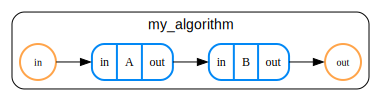

In [8]:
from qref.experimental.rendering import to_graphviz

# Convert the qref format to Graphviz object
gv_object = to_graphviz(my_algorithm_qref)

# Render the Graphviz object to a PNG file
gv_object.render("my_algorithm", format="png")

# Render the Graphviz object in the notebook
gv_object

In this graph, you can see both subroutines from the original algorithm, along with their `names` and`ports`. It provides a general idea of the connectivity between subroutines in the algorithm and shows how information is stored.

## Compilation

 Below you can find depiction of the uncompiled version of `my_algorithm`.
![title](../images/basic_uncompiled.png)

What does "uncompiled" means here?

It means that all the costs and register sizes are expressed using local variables (as in the picture above). What does it mean? Look at this:

In [9]:
uncompiled_routine = my_algorithm_qref.program
uncompiled_routine.children.by_name["A"].resources

[ResourceV1(name='T_gates', type='additive', value='2*n_a + x')]

The cost of `A` is still expressed in terms of its own "local" variables, `n_a` and `x`. Information that we included in `linked_params` has not yet been propagated into `A`.

We also don't know yet what's the size of the output port:

In [10]:
uncompiled_routine.ports.by_name["out"]

PortV1(name='out', direction='output', size=None)

Most importantly, we don't know what is the total cost of the algorithm:

In [11]:
uncompiled_routine.resources

[]

So what we want to do, is to get to the following picture:
![title](../images/basic_compiled.png)

You can compare it with the previous picture and see how "local" variables have been replaced with "global" ones.

We do this with the following command:

In [12]:
from bartiq import compile_routine
compiled_routine = compile_routine(my_algorithm_qref).routine

Now let's check the same fields of our `compiled_routine` object:

In [13]:
print("T gates for A:", compiled_routine.children["A"].resources["T_gates"].value)
print("Output size:", compiled_routine.ports["out"].size)
print("Total T gates:", compiled_routine.resources["T_gates"].value)

T gates for A: 2*n + z
Output size: 2*n + z
Total T gates: 2*n*z*ceiling(log2(2*n)) + 2*n + z


Since the resources in the children have type `additive`, `bartiq` automatically added the `T_gates` resource to the parent as a sum of the resources of the children.

## Evaluation

Now it would be good to know what is the cost when we subsitute some numbers. We can do this using `evaluate` method. As you can see in the example below, it can either substitute all the parameters or just some of them.

In [14]:
from bartiq import evaluate

print("Different values of n:")
for n in range(6, 16, 2):
    assignments = {"n": n}
    evaluated_routine = evaluate(compiled_routine, assignments).routine
    print(f"n = {n}, total T gates:", evaluated_routine.resources["T_gates"].value)

z = 5
assignments = {"n": n, "z": z}
evaluated_routine = evaluate(compiled_routine, assignments).routine
print(f"For n={n}, z={z}")

print("Total T gates:", evaluated_routine.resources["T_gates"].value)

Different values of n:
n = 6, total T gates: 49*z + 12
n = 8, total T gates: 65*z + 16
n = 10, total T gates: 101*z + 20
n = 12, total T gates: 121*z + 24
n = 14, total T gates: 141*z + 28
For n=14, z=5
Total T gates: 733


## Summary
Let's sum up what we covered in this tutorial:

- How to construct a simple algorithm to use with `bartiq`
- How to compile an estimate
- How to evaluate an estimate
- How to use the `qref` visualization tool to visualize an algorithm

In the next tutorial we'll cover how to implement a more complex algorithm from a paper.